In [ ]:
# !pip install scikit-learn nltk numpy scipy torch 

In [117]:
from sklearn.datasets import fetch_20newsgroups
import collections 
import numpy as np
from scipy.spatial.distance import cdist

import nltk
# nltk.download() <-- сюда впишите строкой то, чего ему не хватит при работе базовых функций

from nltk import wordpunct_tokenize, sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
import re
import os

In [2]:
cats = ['alt.atheism', 'sci.space', 'rec.sport.hockey', 'sci.med']
data = fetch_20newsgroups(subset='train', categories=cats)['data']

In [3]:
np.random.shuffle(data)

In [4]:
print(np.random.choice(data, 1)[0])

Organization: Queen's University at Kingston
From: Graydon <SAUNDRSG@QUCDN.QueensU.CA>
Subject: Re: What if the USSR had reached the Moon first?
 <dxb105.734155421@aries> <1993Apr7.124724.22534@yang.earlham.edu>
 <dxb105.734495289@virgo> <1993Apr12.161742.22647@yang.earlham.edu>
 <93107.144339SAUNDRSG@QUCDN.QueensU.CA> <1993Apr18.091051.14496@ke4zv.uucp>
Lines: 38

In article <1993Apr18.091051.14496@ke4zv.uucp>, gary@ke4zv.uucp (Gary Coffman)
says:
>In article <93107.144339SAUNDRSG@QUCDN.QueensU.CA> Graydon
><SAUNDRSG@QUCDN.QueensU.CA> writes:
>>This is turning into 'what's a moonbase good for', and I ought
>>not to post when I've a hundred some odd posts to go, but I would
>>think that the real reason to have a moon base is economic.
>>Since someone with space industry will presumeably have a much
>>larger GNP than they would _without_ space industry, eventually,
>>they will simply be able to afford more stuff.
>
>If I read you right, you're saying in essence that, with a larger
>econ

In [ ]:
# Будем использовать тексты из 20 news groups

In [ ]:
# Для начала реализуйте препроцессинг. Наша цель как можно сильнее сократить словарь, оставив только значимые 
# токены, которые будем учиться предсказывать. Убираем все потенциальные формы слова, слова со спец. знаками, 
# числа и заглавные буквы. Тексты поделите на предложения, чтобы не перемешивать контексты

In [12]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /Users/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/anna/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
# TODO: реализуйте препроцессинг текста.
# INPUT: строка текста
# OUTPUT: вложенный список токенов

s = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text= str(text).lower()
    sents = sent_tokenize(text)
    sents = [re.sub(r"\d+", " ", sent) for sent in sents]
    sents = [re.sub(r"[^\w\s]", " ", sent.strip()) for sent in sents]
    sents = [word_tokenize(sent) for sent in sents]
    sents = [[word for word in sent if word not in stop_words] for sent in sents]
    sents = [[s.stem(word) for word in sent] for sent in sents]  
    sents = [[word for word in sent if word.isalpha() == True and len(word) > 3] for sent in sents] 
    sents = [list for list in sents if len(list) > 1]
    return sents

In [13]:
data = [preprocess(text) for text in data]

# Это такой flattener ...
data = [item for sublist in data for item in sublist]

In [14]:
len(data) # <---  общее количество предложений во всем корпусе

33685

In [15]:
# Создадим отображение токенов в пространство чисел и обратно
# С помощью такого отбражения будем кодировать (чтобы подать в нейросеть) 
# и раскодировать наши слова (после предсказания)

# Для начала создайте уникальный список слов. Используйте оптимальные структуры данных
vocabulary = set()
for lists in data:
    vocabulary.update(lists)
    

# Создайте два словаря. 
# word2idx: из слова в уникальное число (можно воспользоваться enumerate())
word2idx = {}
for i,word in enumerate(vocabulary):
    word2idx[word] = i

# idx2word: из числа обратно в слово
idx2word = {val:key for key, val in word2idx.items()}

# Размер словаря
vocabulary_size = len(vocabulary)
print(vocabulary_size)


20131


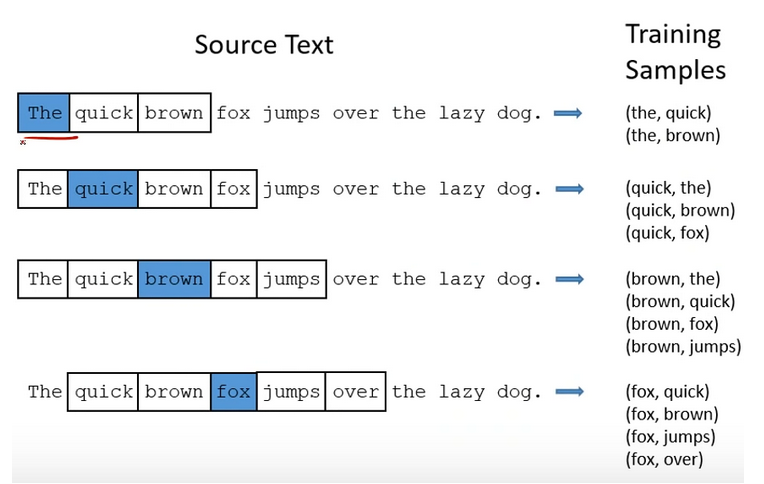

In [16]:
# Теперь необходимо написать функцию, которая создаёт список контекстов из списка токенов (см изображение выше)
# При этом она принимает параметр window, который говорит нам о том, сколько слов слева и справа от текущего центрального
# слова нам нужно взять. 

def make_contexts(sent, window=2):
    # INPUT: токенизированное предложение
    # OUTPUT: вложенный список контекстов.
    # Каждый контекст состоит из двух токенов: центральный и сосед

    contexts = []
    for i in range(len(sent)):
        try:
            central_word = sent[i]
            for j in range(i-window, i+window+1):
                if i != j and j >= 0:
                    contexts.append([central_word, sent[j]])
                
                
        except IndexError:
            pass
    
    return contexts



In [17]:
# Проверка работы вашей функции

test_case = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
test_truth = [l.strip().split('\t') for l in open('test.tsv')]

assert make_contexts(test_case, 2) == test_truth

In [18]:
# Делаем контексты

data = [make_contexts(sent) for sent in data]

# Опять flattener ...
data = [item for sublist in data for item in sublist]

In [128]:
# Теперь реализуем архитектуру Word2Vec.
# Word2vec - это нейросеть с одним скрытым слоем.
# На лекции мы говорили, что для того, чтобы выбрать нужный вектор столбец из нашего "первого слоя"
# (хотя к нему можно относиться и как к входному) нужно умножить one-hot вектор на соответствующую матрицу 
# размера (vocab_size, emb_size). 
# В pytorch всё можно сделать ещё проще. Пропустим шаг с созданием one-hot вектора и сразу же
# извлечем наш вектор из слоя, который называется nn.Embedding с помощью индекса нашего токена (помните  word2idx?)
# Затем (без активации) пропустим через наш простой линейный (i.e. полносвязный) слой
# После активации мы получаем распределение вероятностей для предсказанного токена.

class W2V(nn.Module):
    def __init__(self, vocab_size, word2idx, idx2word, emb_size=5):
        super(W2V, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.word2idx = word2idx
        self.idx2word = idx2word
        
        # Матрица u --> эмбеддинг слой, который мы ожидаем, что будет содержать в себе семантику слов после обучения
        # Размер (vocab_size, emb_size). Задайте ему также параметр sparse
        self.u_emb = nn.Embedding(vocab_size, emb_size, sparse=True)
        
        # Матрица v --> преобразует скрытое состояние в вектор (или матрицу, если батч) размера количества слов
        # Размер (emb_size, vocab_size)
        self.v_emb = nn.Embedding(emb_size, vocab_size, sparse=True)
    
    def __getitem__(self, i):
        """
            get embedding of a word of shape (1, emb_size)
        """
        return self.u_emb(torch.LongTensor([i]))
       


    def top_k_closest(self, word, k):
        """
            top-k cosine-closest words
        """
        # Попробуйте не пользоваться cdist, а использовать функционал PyTorch для этого
        data = self.u_emb.weight.data #наш tensor с данными
        idx = torch.tensor(self.word2idx[word], dtype=torch.long).unsqueeze(0) # индекс входного слова
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        k_sim = {}
        
        for i,word_emb in enumerate(data):  #проходимся по эмбеддингам и добавляем в словарь слово в обычном виде
            k_sim[self.idx2word[i]] = cos(data[idx], word_emb)
        
        k_most_sim = collections.Counter(k_sim)
        return k_most_sim.most_common(k)
            
            
    
    def forward(self, x):
        """
           x: idx of center word
        """
        x = self.u_emb(x) # forward emb layer
        x = self.v_emb(x) # forward linear layer
        return x

In [123]:
c = W2V(vocabulary_size, word2idx, idx2word)

In [127]:
c.top_k_closest('queen', 8)

[('queen', tensor([1.])),
 ('pqdor', tensor([0.9887])),
 ('khimik', tensor([0.9851])),
 ('cormierj', tensor([0.9840])),
 ('scare', tensor([0.9830])),
 ('acdi', tensor([0.9822])),
 ('reed', tensor([0.9821])),
 ('yashin', tensor([0.9820]))]

In [129]:
emb_size = 50
num_epochs = 200
learning_rate = 0.001

In [131]:
model = W2V(len(idx2word), emb_size, idx2word)

# Cross Entropy
criterion = torch.nn.CrossEntropyLoss()

# SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [132]:
model['hi'] # Модель должна ещё вот такое благодаря __getitem__ <---

ValueError: too many dimensions 'str'

In [ ]:
# Напишем наш цикл обучения. Попробуем реализовать простенько, без батчей.
# Но будем копить градиент и каждые 100 итераций обновлять веса

for epo in range(num_epochs):
    
    loss_val = 0
    for center, context in tqdm.tqdm(data):

        # Пропускаем слово через модель
        z = model(center)
        
        # Активируем софтмаксом
        z = None
        
        # Считаем лосс (он принимает распределение предсказанных вероятностей и правильный ответ)
        # Скорее всего нужно сделать reshape с помощью view
        loss = None
        
        # Копим общий лосс, и надеямся, что на следующей эпохи накопится поменьше
        loss_val += loss
        
        # Проверяем, прошло ли 100 итераций.
        # Если да:
        # 1) зануляем градиенты с предыдущего шага оптимизатора
        # 2) backprop
        # 3) шаг оптимизации
        
    # Выведем усредненный на количество пар лосс
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

In [ ]:
# Тут поэкспериментруйте с тем, что получилось. Можно с помощью метода top_k_closest.
# Не расстраивайтесь, если результаты не очень. Мы обучили упрощенную модель и на очень маленьком корпусе. 
# Можете попробовать скормить модели еще более упрощенные данные с маленьким размером словаря.
